I wanted to analyse if betting on football is profitable or not for noobs who have little or no knowledge of the sport. Others on Kaggle have analysed & found that home advantage is a significant factor in football, & more often than not the home team is the bookies' favourite to win the match. I'll investigate  a **few simple betting approaches** with applying different **financial strategies** - 

1.  Bet on the **safest outcome** for every match (i.e, the one with lowest  odds).  
2. Bet on the **underdog** (most unlikely outcome)  for every match (i.e, the  one with highest odds).
3. Bet on the **home team** for every match

Use following financial strategies:
1. **Flat** - fixed stake
2. **Expected Profit** - hope this approach has correct naming, main idea that I want to get fixed profit per each stake.

and in next series will use:
- **Fixed Percent Of Bank** - bet every time with fixed percent of bank, eg 1%
- **Progressive System** - just simple Martingale as well-known approach.

I'm using the odds from Bet365 mostly due more matches ...

In [90]:
#include libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

## Data Mungling

In [182]:
BOOKIE = {
    'BET365': ['B365H', 'B365D', 'B365A'],
    'PS': ['PSH', 'PSD', 'PSA'],
    'WH': ['WHH', 'WHD', 'WHA'],
    'BWIN': ['BWH', 'BWD', 'BWA'],
    'LB': ['LBH', 'LBD', 'LBA'] 
}

MATCH = [
    'id', 'season', 'match_api_id', 'date', 'country_id', 'league_id', 'stage',  'goal',
    'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal'
]
MATCH_INFO = [
    'date', 'season','name', 'stage', 'team_long_name_home', 
    'team_long_name_away', 'home_team_goal', 'away_team_goal'
]

#load the data. (P.S - copied this from Yoni Lev's Kernel)
def load_data():
    with sqlite3.connect('./database.sqlite') as con:
        countries = pd.read_sql_query("SELECT * from Country", con)
        matches = pd.read_sql_query("SELECT * from Match", con)
        leagues = pd.read_sql_query("SELECT * from League", con)
        teams = pd.read_sql_query("SELECT * from Team", con)
    return countries, matches, leagues, teams


def load_and_normalize_data(bookie='BET365'):
    countries, matches, leagues, teams = load_data()
    
    match_info = pd.merge(
        left=matches[MATCH + BOOKIE[bookie]], 
        right=teams[['team_api_id', 'team_long_name']], 
        how='left',
        left_on='home_team_api_id',
        right_on='team_api_id',
        suffixes=('', '_t')
    )

    match_info = pd.merge(
        left=match_info, 
        right=teams[['team_api_id', 'team_long_name']], 
        how='left',
        left_on='away_team_api_id',
        right_on='team_api_id',
        suffixes=('_home', '_away')

    )

    match_info = pd.merge(
        left=match_info, 
        right=leagues[['country_id', 'name']], 
        how='left',
        left_on='country_id',
        right_on='country_id',
        suffixes=('_home', '_away')

    )

    match_info = match_info[MATCH_INFO + BOOKIE[bookie]].rename(
        columns={
            'name': 'championat',
            'team_long_name_home': 'home_team',
            'team_long_name_away': 'away_team',
        }
    )
    match_info.columns = [col.upper() for col in match_info.columns]
    match_info = match_info.sort_values(by='DATE', ascending=True)
    print('Dataset[Full] Shape = {}'.format(match_info.shape))
    match_info = match_info.dropna()
    print('Dataset[DropNA] Shape = {}'.format(match_info.shape))
    
    return match_info

In [184]:
# Total Matches Over Seasons
data = load_and_normalize_data(bookie='BET365')
season_gr = data[['CHAMPIONAT', 'SEASON']].groupby(by=['CHAMPIONAT', 'SEASON']).size().unstack(fill_value=0)
season_gr

Dataset[Full] Shape = (25979, 11)
Dataset[DropNA] Shape = (22592, 11)


SEASON,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
CHAMPIONAT,,,,,,,,
Belgium Jupiler League,303,210,240,238,235,0,240,240
England Premier League,380,380,380,380,380,380,380,380
France Ligue 1,379,379,379,380,380,380,380,379
Germany 1. Bundesliga,306,306,306,306,305,306,306,306
Italy Serie A,380,379,377,357,379,380,379,380
Netherlands Eredivisie,305,305,306,306,305,306,306,306
Portugal Liga ZON Sagres,238,239,239,238,240,239,305,306
Scotland Premier League,228,228,228,228,228,228,228,228
Spain LIGA BBVA,379,380,380,380,380,380,380,380


## Utilities To Apply Results and Strategies

In [186]:
def apply_result_on_favorite(x):
#     print(x.values)
    _result, _home, _draw, _away = x
    
    if (min(_home, _draw, _away) == _home) and (_result == 'H'):
        return 'H'
    elif (min(_home, _draw, _away) == _draw) and (_result == 'D'):
        return 'D'
    elif (min(_home, _draw, _away) == _away) and (_result == 'A'):
        return 'A'
    else:
        return 'OTHER'
        
        
def apply_result_on_dog(x):
#     print(x.values)
    _result, _home, _draw, _away = x
    
    if (max(_home, _draw, _away) == _home) and (_result == 'H'):
        return 'H'
    elif (max(_home, _draw, _away) == _draw) and (_result == 'D'):
        return 'D'
    elif (max(_home, _draw, _away) == _away) and (_result == 'A'):
        return 'A'
    else:
        return 'OTHER'

def apply_results(match_info):
    #compute the match result (i.e Home win/Draw/Away win) from the goals data for the match
    match_info['RESULT'] = 'H'
    match_info.loc[match_info.HOME_TEAM_GOAL == match_info.AWAY_TEAM_GOAL, "RESULT"] = 'D'
    match_info.loc[match_info.HOME_TEAM_GOAL < match_info.AWAY_TEAM_GOAL, "RESULT"] = 'A'

    match_info.loc[:, 'ODDS_ON_HOME'] = match_info['B365H']
    match_info.loc[:, 'ODDS_ON_FAVORITE'] = match_info[['B365H', 'B365D', 'B365A']].min(axis=1)
    match_info.loc[:, 'ODDS_ON_DOG'] = match_info[['B365H', 'B365D', 'B365A']].max(axis=1)

    #find the match outcome corresponding to the safest & riskiest odds
    match_info.loc[:, 'RESULT_ON_HOME'] = 'OTHER'
    match_info.loc[match_info.RESULT == 'H', 'RESULT_ON_HOME'] = 'H'

    match_info.loc[:, 'RESULT_ON_FAVORITE'] = match_info[['RESULT', 'B365H', 'B365D', 'B365A']].apply(
        apply_result_on_favorite,
        axis='columns'
    )

    match_info.loc[:, 'RESULT_ON_DOG'] = match_info[['RESULT', 'B365H', 'B365D', 'B365A']].apply(
        apply_result_on_dog,
        axis='columns'
    )
    return match_info


FLAT_STAKE = 10
BANK = 1000
DESIRE_PROFIT = 20

def apply_finance_strategy(match_info, strategy='FLAT'):
    if strategy == 'FLAT':
        match_info['STAKE_ON_HOME'] = FLAT_STAKE
        match_info['STAKE_ON_FAVORITE'] = FLAT_STAKE
        match_info['STAKE_ON_DOG'] = FLAT_STAKE
    else:
        match_info['STAKE_ON_HOME'] = float(DESIRE_PROFIT) / (match_info.ODDS_ON_HOME - 1)
        match_info['STAKE_ON_FAVORITE'] = float(DESIRE_PROFIT) / (match_info.ODDS_ON_FAVORITE - 1)    
        match_info['STAKE_ON_DOG'] = float(DESIRE_PROFIT) / (match_info.ODDS_ON_DOG - 1)
        
    match_info['PAYOUT_ON_HOME'] =  match_info.ODDS_ON_HOME * match_info.STAKE_ON_HOME
    match_info.loc[~(match_info.RESULT_ON_HOME == match_info.RESULT), 'PAYOUT_ON_HOME'] = 0

    match_info['PAYOUT_ON_FAVORITE'] = match_info.ODDS_ON_FAVORITE * match_info.STAKE_ON_FAVORITE
    match_info.loc[~(match_info.RESULT_ON_FAVORITE == match_info.RESULT), 'PAYOUT_ON_FAVORITE'] = 0
    
    match_info['PAYOUT_ON_DOG'] = match_info.ODDS_ON_DOG * match_info.STAKE_ON_DOG
    match_info.loc[~(match_info.RESULT_ON_DOG == match_info.RESULT), 'PAYOUT_ON_DOG'] = 0
    
    return match_info


def get_stats_from_matches(match_info, need_print=False):
    if match_info.shape[0] == 0:
        return None, None, None
    percent_on_home = match_info[~(match_info.PAYOUT_ON_HOME == 0)].shape[0] / float(match_info.shape[0])
    percent_on_favorite = match_info[~(match_info.PAYOUT_ON_FAVORITE == 0)].shape[0] / float(match_info.shape[0])
    percent_on_dog = match_info[~(match_info.PAYOUT_ON_DOG == 0)].shape[0] / float(match_info.shape[0])
    
    investment_on_home = match_info.STAKE_ON_HOME.sum()
    investment_on_favorite = match_info.STAKE_ON_FAVORITE.sum()
    investment_on_dog = match_info.STAKE_ON_DOG.sum()

    roi_on_home = sum(match_info.PAYOUT_ON_HOME)
    roi_on_favorite = sum(match_info.PAYOUT_ON_FAVORITE)
    roi_on_dog = sum(match_info.PAYOUT_ON_DOG)
    # calculate percantage reduction error what we stake vs earcn in %
    pre_on_home = (roi_on_home - investment_on_home)/investment_on_home * 100
    pre_on_favorite = (roi_on_favorite - investment_on_favorite)/investment_on_favorite * 100
    pre_on_dog = (roi_on_dog - investment_on_dog)/investment_on_dog * 100
    if need_print:
        print ("Correct bets for home={} | favorite={} | dog={}".format(percent_on_home, percent_on_favorite, percent_on_dog))
        print ("Net investment:", net_investment)
        print ("ROI for home={} | favorite={} | dog={}".format(roi_on_home, roi_on_favorite, roi_on_dog))
        print ("PRE for home={} | favorite={} | dog={}:".format(pre_on_home, pre_on_favorite, pre_on_dog))
    return pre_on_home, pre_on_favorite, pre_on_dog


def generate_stats_over_all_seasons(match_info):
    profitablity = {}
    stats_on_home = {}
    stats_on_favorite = {}
    stats_on_dog = {}

    for champ in match_info['CHAMPIONAT'].unique():
        for season in match_info['SEASON'].unique():
    #         print('Processing -> {} - {}'.format(champ, season))
            match_df = match_info[
                (match_info['CHAMPIONAT'] == champ) & 
                (match_info['SEASON'] == season)
            ]
            on_home, on_favorite, on_dog = get_stats_from_matches(match_df)
            profitablity.setdefault(champ, {}).setdefault(
                season, 
                {
                    'BET_ON_HOME': on_home,
                    'BET_ON_FAVORITE': on_favorite,
                    'BET_ON_DOG': on_dog
                }
            )
            stats_on_home.setdefault(champ, {}).setdefault(season, on_home)
            stats_on_favorite.setdefault(champ, {}).setdefault(season, on_favorite)
            stats_on_dog.setdefault(champ, {}).setdefault(season, on_dog)
    
    return profitablity, stats_on_home, stats_on_favorite, stats_on_dog

## Start Rock&Roll

In [187]:
match_results = apply_results(data)
match_results.loc[:, [
    'RESULT', 'RESULT_ON_HOME', 'RESULT_ON_FAVORITE', 'RESULT_ON_DOG', 
    'ODDS_ON_HOME', 'ODDS_ON_FAVORITE', 'ODDS_ON_DOG',
    'B365H', 'B365D', 'B365A']].head(5)

,RESULT,RESULT_ON_HOME,RESULT_ON_FAVORITE,RESULT_ON_DOG,ODDS_ON_HOME,ODDS_ON_FAVORITE,ODDS_ON_DOG,B365H,B365D,B365A
19693,A,OTHER,A,OTHER,6.50,1.50,6.50,6.50,4.00,1.50
4774,D,OTHER,OTHER,OTHER,2.15,2.15,3.60,2.15,3.10,3.60
19694,H,H,H,OTHER,2.00,2.00,3.25,2.00,3.25,3.25
4777,H,H,H,OTHER,2.40,2.40,3.10,2.40,3.10,3.10
4776,A,OTHER,OTHER,A,1.91,1.91,4.33,1.91,3.20,4.33


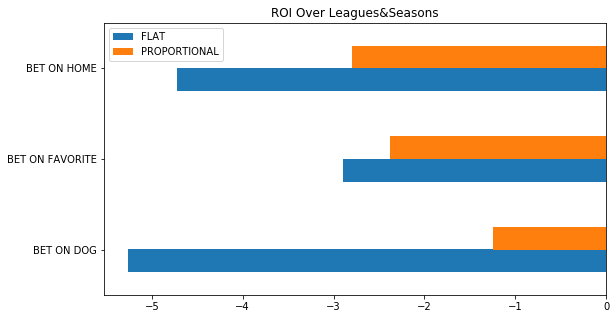

In [188]:
# Calculate ROI over for all matches
strategies_stats = {}
for strg in ['FLAT', 'PROPORTIONAL']:
    match_info = apply_finance_strategy(match_results, strategy=strg)
    on_home, on_favorite, on_dog = get_stats_from_matches(match_info)
    strategies_stats.setdefault(
        strg, {
            'BET ON HOME': on_home, 
            'BET ON FAVORITE': on_favorite, 
            'BET ON DOG': on_dog
        }
    )
pd.DataFrame(strategies_stats).plot(kind='barh', figsize=(9,5), title='ROI Over Leagues&Seasons')

In [189]:
# 
detail_strategies_stats = {}
for strg in ['FLAT', 'PROPORTIONAL']:
    match_info = apply_finance_strategy(match_results, strategy=strg)
    _, stats_on_home, stats_on_favorite, stats_on_dog = generate_stats_over_all_seasons(match_info)
    detail_strategies_stats.setdefault(
        strg, {
            'BET ON HOME': stats_on_home, 
            'BET ON FAVORITE': stats_on_favorite, 
            'BET ON DOG': stats_on_dog
        }
    )

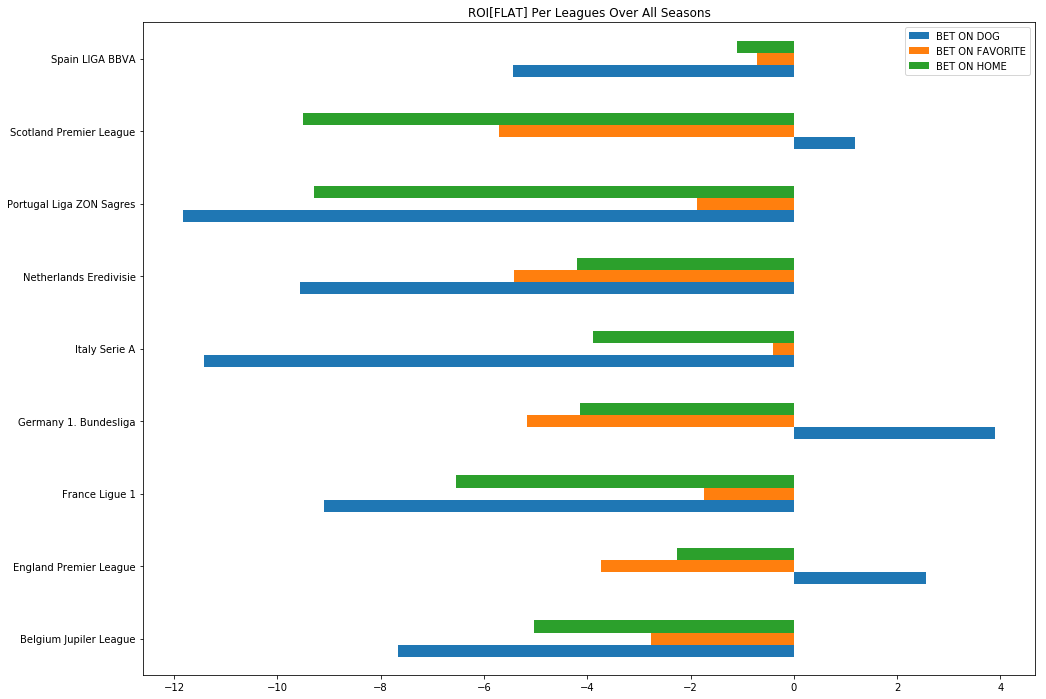

In [206]:
tmp = {}
for strg in ['BET ON HOME', 'BET ON FAVORITE', 'BET ON DOG']:
    tmp.setdefault(strg, pd.DataFrame(detail_strategies_stats['FLAT'][strg]).mean())
    
pd.DataFrame(tmp).plot(kind='barh', figsize=(16,12), title='ROI[FLAT] Per Leagues Over All Seasons')

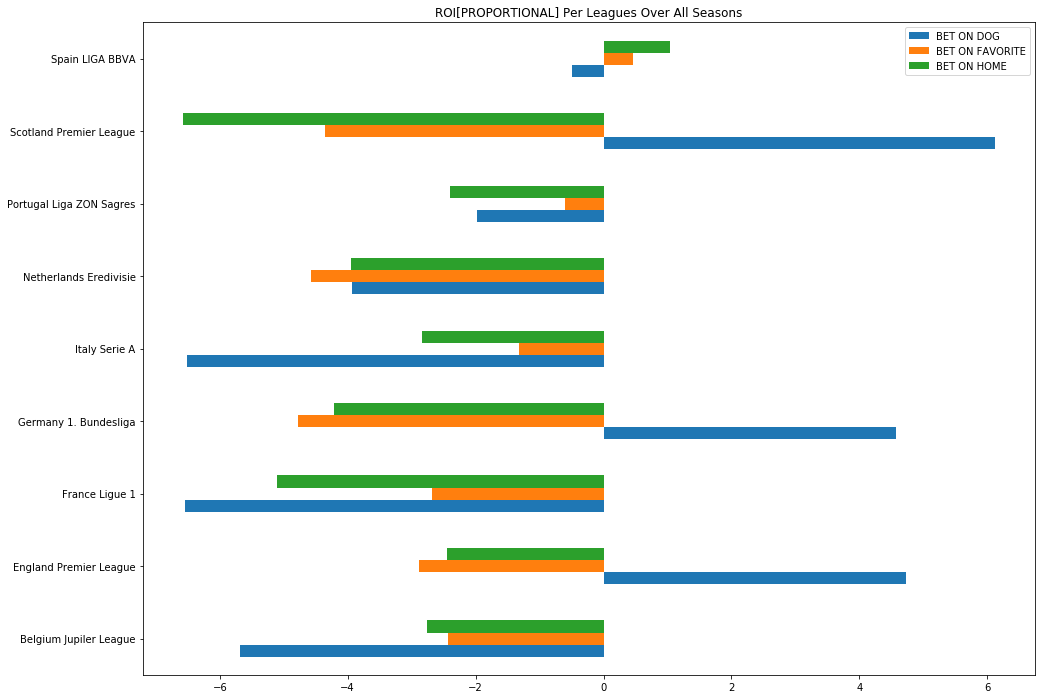

In [207]:
tmp = {}
for strg in ['BET ON HOME', 'BET ON FAVORITE', 'BET ON DOG']:
    tmp.setdefault(strg, pd.DataFrame(detail_strategies_stats['PROPORTIONAL'][strg]).mean())
    
pd.DataFrame(tmp).plot(kind='barh', figsize=(16,12), title='ROI[PROPORTIONAL] Per Leagues Over All Seasons')

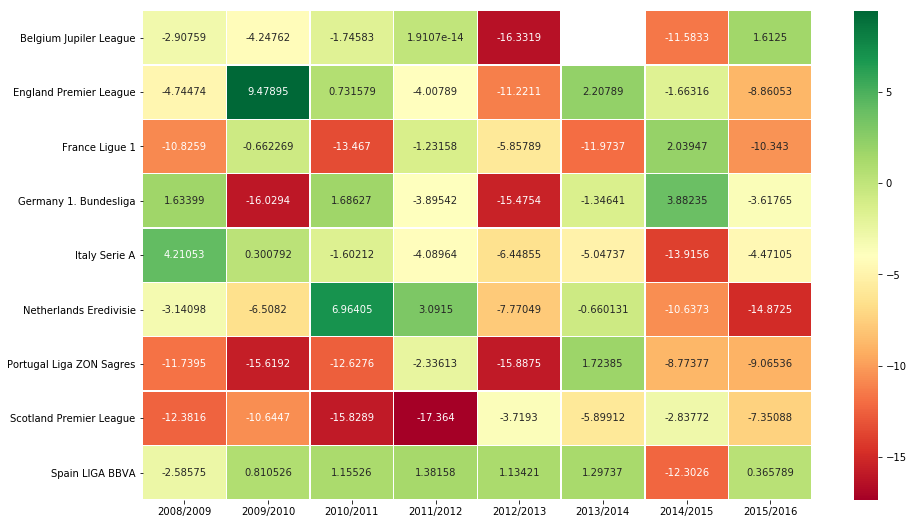

In [210]:
fig, ax = plt.subplots(figsize=(15, 9))   
sns.heatmap(
    pd.DataFrame(detail_strategies_stats['FLAT']['BET ON HOME']).T, 
    annot=True, 
    fmt="g", 
    cmap="RdYlGn",
    linewidths=.5,
    ax=ax
)


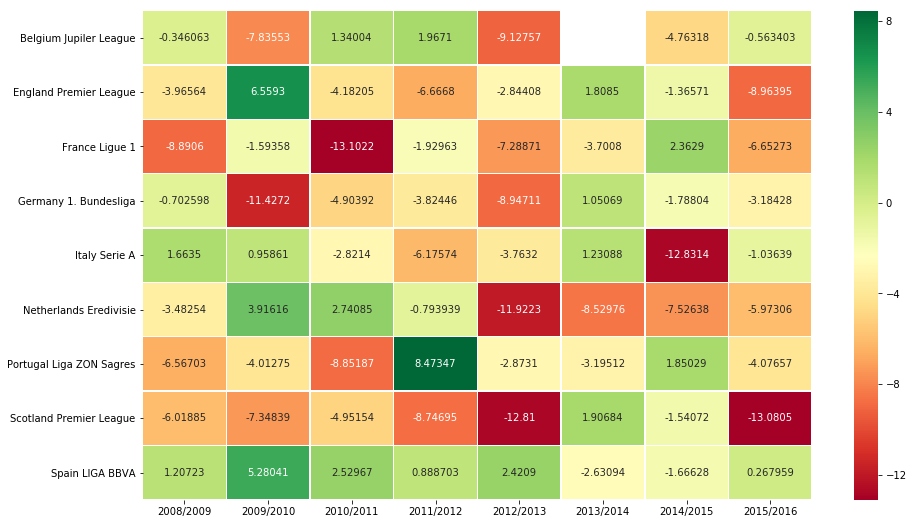

In [213]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(
    pd.DataFrame(detail_strategies_stats['PROPORTIONAL']['BET ON HOME']).T, 
    annot=True, 
    fmt="g", 
    cmap="RdYlGn",
    linewidths=.5,
    ax=ax
)

## Summary

As expected and report shows: 
- financial managment does matter!
- naive strategies is supposed to lose in long game due bookies margin.


Also visualization even those naive steps really help to see some patterns/outliers, and we will continue reveal more tricks in next posts.

In [215]:
# to be continued ...